# BETO Fine-Tuning Acronym Classification


## Enviroment

### Activating the GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Installing the Hugging Face PyTorch Interface for Bert

In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp
!pip install -q transformers

     |████████████████████████████████| 133kB 12.4MB/s eta 0:00:01
     |████████████████████████████████| 92kB 8.4MB/s  eta 0:00:01
     |████████████████████████████████| 133kB 22.0MB/s 
     |████████████████████████████████| 7.6MB 18.4MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
ERROR: botocore 1.20.90 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 2.3MB 10.3MB/s 
     |████████████████████████████████| 3.3MB 34.0MB/s 
     |████████████████████████████████| 901kB 30.7MB/s 


### Importing the modules

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertForMaskedLM
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
% matplotlib inline

### Specifying CUDA as the device for Torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## Data

In [5]:
df = pd.read_csv("train_data_beto_10.csv", delimiter=',')
df.shape

(6360, 5)

In [6]:
df.sample(10)

,Unnamed: 0,short_form,context,long_form,label
3028,3028,h,"y prealbúmina : 36,9 mg/dL . Proteinuria : 2.1...",hora,1
5502,5502,UCI,la última toma de Rivaroxabán . Tras su ingres...,unidad cuidado intensivo,1
2783,2783,Hgb,Síndrome de Stevens Jonson . El laboratoria mo...,hemoglobina,1
2871,2871,µl,ingreso se obtuvieron los siguiente resultados...,microlitro,1
147,147,cm,otra imagen de aspecto nodular de 2 cm x 2 < s...,centimetro agua,0
242,242,FVC,; FEV1 56 % ; PEF 73 % ; FEV1/ < start > FVC <...,forced vital capacity,1
2835,2835,ALT,91mg/dl ; bilirrubina total 21mg/dl ; AST 164 ...,alanine transaminar,0
513,513,Dpto.,. El análisis químico-toxicológico realizado e...,departamento,1
5646,5646,mg,quimioterápico con esquema mFOLFOX 6 + Bevaciz...,miligramo,1
839,839,mm,"culata plegable y bocacha apagallamas , calibr...",milimetro,1


In [7]:
df = df[['short_form', 'context','long_form', 'label']]

In [9]:
# Adding CLS and SEP tokens at the beginning and end of each LF for BETO
df['sentences'] = df['long_form'].map(lambda x: "[CLS] " + x + " [SEP] ")+df['context'] + ' [SEP]'

In [10]:
df.head()

,short_form,context,long_form,label,sentences
0,dl,"del líquido una glucorraquia normal , proteino...",decilitro,1,[CLS] decilitro [SEP] del líquido una glucorra...
1,dl,"que eran de 5,8 g/dl con albúmina de 1.400 mg/...",decilitro,1,"[CLS] decilitro [SEP] que eran de 5,8 g/dl con..."
2,dl,"67 y las proteínas totales que eran de 5,8 g/ ...",decilitro,1,[CLS] decilitro [SEP] 67 y las proteínas total...
3,dl,las pruebas realizadas destacaba una anemia no...,decilitro,1,[CLS] decilitro [SEP] las pruebas realizadas d...
4,g,gamma-GT 67 y las proteínas totales que eran d...,gramo,1,[CLS] gramo [SEP] gamma-GT 67 y las proteínas ...


In [11]:
#Creating sentence, label lists and adding Bert tokens
sentences = df.sentences.values

labels = df.label.values

In [12]:
sentences[:3]

array(['[CLS] decilitro [SEP] del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end > 960 células/mm3 un 90 % de las cuales se correspondían [SEP]',
       '[CLS] decilitro [SEP] que eran de 5,8 g/dl con albúmina de 1.400 mg/ < start > dl < end > El elemental de orina y sedimento eran normales , así [SEP]',
       '[CLS] decilitro [SEP] 67 y las proteínas totales que eran de 5,8 g/ < start > dl < end > con albúmina de 1.400 mg/dl . El elemental de orina [SEP]'],
      dtype=object)

### Activating the BETO Tokenizer

In [13]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])



Tokenize the first sentence:
['[CLS]', 'deci', '##li', '##tro', '[SEP]', 'del', 'líquido', 'una', 'gluc', '##orra', '##quia', 'normal', ',', 'prote', '##ino', '##r', '##ra', '##quia', 'de', '102', 'mg', '/', '<', 'star', '##t', '>', 'd', '##l', '<', 'end', '>', '9', '##6', '##0', 'células', '/', 'mm', '##3', 'un', '90', '%', 'de', 'las', 'cuales', 'se', 'correspondía', '##n', '[SEP]']


### Processing Data

In [15]:
# Set the maximum sequence length.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [16]:
input_ids[0]

array([    4,  1338,  3018,  1199,     5,  1081, 12570,  1091, 22447,
        8833,  5470,  4783,  1019,  6109,  1501, 30960,  1052,  5470,
        1009, 15303, 16056,   989,   983,  5870, 30964,   981,  1007,
       30962,   983, 17788,   981,  1586,  1000, 30987,  7911,   989,
        5551, 31000,  1044,  4313,   991,  1009,  1085,  3523,  1057,
       24667, 30959,     5,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [17]:
#Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [18]:
attention_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [19]:
#Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [20]:
#Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [21]:
#Selecting a Batch Size and Creating and Iterator 
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Bert Configuration 

In [22]:
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers
  


# Initializing a model from the bero-basestyle configuration
model1 = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels = 2)
model2 = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels = 2)

# Accessing the model configuration
configuration1 = model1.config
configuration2 = model2.config
print(configuration1)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

BertConfig {
  "_name_or_path": "dccuchile/bert-base-spanish-wwm-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31002
}



In [23]:
model1.cuda()
model2.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Optimizer Grouped Parameters

In [24]:
param_optimizer1 = list(model1.named_parameters())
param_optimizer2 = list(model2.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters1 = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer1 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer1 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer_grouped_parameters2 = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer2 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer2 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

### The Hyperparemeters for the Training Loop

In [25]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer1 = AdamW(optimizer_grouped_parameters1,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
optimizer2 = AdamW(optimizer_grouped_parameters2,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler1 = get_linear_schedule_with_warmup(optimizer1, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler2 = get_linear_schedule_with_warmup(optimizer2, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [26]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# The Training Loop

### Model 1

In [28]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model1.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer1.zero_grad()
    # Forward pass
    outputs = model1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer1.step()

    # Update the learning rate.
    scheduler1.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model1.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()


    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.43681424976893646


Epoch:  25%|██▌       | 1/4 [03:53<11:41, 233.80s/it]

Validation Accuracy: 0.9035714285714287
Train loss: 0.2309924849834522


Epoch:  50%|█████     | 2/4 [07:47<07:47, 233.71s/it]

Validation Accuracy: 0.9095982142857142
Train loss: 0.18980093789416985


Epoch:  75%|███████▌  | 3/4 [11:40<03:53, 233.66s/it]

Validation Accuracy: 0.9120535714285714
Train loss: 0.15795539476643394


Epoch: 100%|██████████| 4/4 [15:34<00:00, 233.52s/it]

Validation Accuracy: 0.9151785714285714


### Model 2

In [29]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model2.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer1.zero_grad()
    # Forward pass
    outputs = model2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer2.step()

    # Update the learning rate.
    scheduler2.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model2.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.7446291834615463


Epoch:  25%|██▌       | 1/4 [03:53<11:39, 233.12s/it]

Validation Accuracy: 0.6912946428571429
Train loss: 0.8624495059751266


Epoch:  50%|█████     | 2/4 [07:46<07:46, 233.27s/it]

Validation Accuracy: 0.3087053571428572
Train loss: 0.8010283045928571


Epoch:  75%|███████▌  | 3/4 [11:41<03:53, 233.68s/it]

Validation Accuracy: 0.6881696428571429
Train loss: 0.7313238455596582


Epoch: 100%|██████████| 4/4 [15:36<00:00, 234.01s/it]

Validation Accuracy: 0.6912946428571429


Training Evaluation

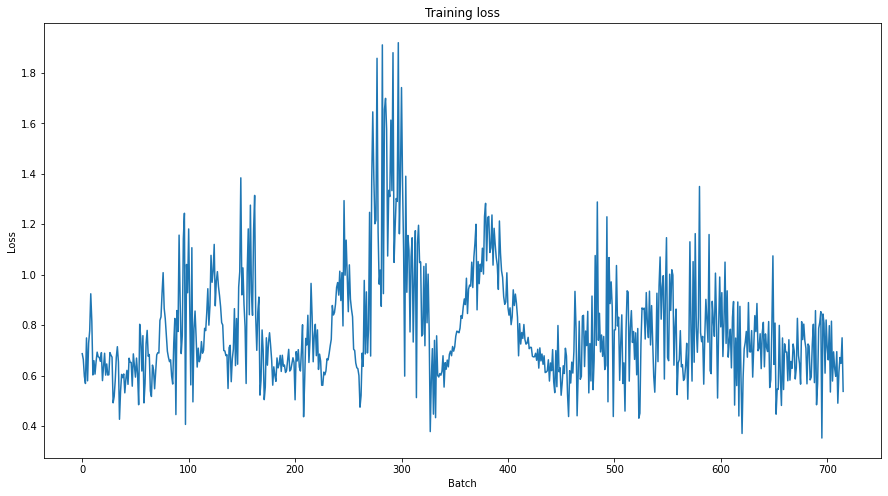

In [30]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Prediction

### Preprocessing test dataset

In [31]:
df_test = pd.read_csv("test_data_beto_10.csv")

df_test['sentences'] = df_test['long_form'].map(lambda x: "[CLS] " + x + " [SEP] ")+df['context'] + ' [SEP]'

# Create sentence and label lists
sentences_test = df_test.sentences.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
# sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels_test = df_test.label.values

tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
# Pad our input tokens
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels_test)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Prediction on test set model 1

In [32]:
# Put model in evaluation mode
model1.eval()

# Tracking variables 
predictions1 , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy= flat_accuracy(logits, label_ids)
    
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1
  
  # Store predictions and true labels
  predictions1.append(logits)
  true_labels.append(label_ids)

In [ ]:
predictions1[:2]

In [34]:
print(len(df_test))
print(len(predictions1))
print(len(true_labels))

4703
147
147


### Prediction on test set model 2

In [35]:
# Put model in evaluation mode
model2.eval()

# Tracking variables 
predictions2 , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    

  # Move logits and labels to CPU
  logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy= flat_accuracy(logits, label_ids)
    
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1
  
  # Store predictions and true labels
  predictions2.append(logits)
  true_labels.append(label_ids)

In [36]:
print(len(predictions2))
print(len(true_labels))

147
147


In [37]:
print(predictions2[:1])

[array([[0.1877912 , 0.81220883],
       [0.1877912 , 0.81220883],
       [0.18779114, 0.81220883],
       [0.18779114, 0.81220883],
       [0.1877912 , 0.81220883],
       [0.18779123, 0.8122087 ],
       [0.1877912 , 0.81220883],
       [0.18779114, 0.81220883],
       [0.18779123, 0.8122087 ],
       [0.1877912 , 0.81220883],
       [0.18779114, 0.81220883],
       [0.18779123, 0.8122087 ],
       [0.18779114, 0.81220883],
       [0.18779114, 0.81220883],
       [0.18779114, 0.81220883],
       [0.18779114, 0.81220883],
       [0.1877912 , 0.81220883],
       [0.1877912 , 0.81220883],
       [0.1877912 , 0.81220883],
       [0.1877912 , 0.81220883],
       [0.18779127, 0.8122087 ],
       [0.18779123, 0.8122087 ],
       [0.1877912 , 0.81220883],
       [0.18779114, 0.81220883],
       [0.18779123, 0.8122087 ],
       [0.18779114, 0.81220883],
       [0.18779118, 0.81220883],
       [0.18779118, 0.81220883],
       [0.18779118, 0.81220883],
       [0.18779118, 0.81220883],
       [0

## Voting Ensemble

In [38]:
predictions1_flat = [i for a in predictions1 for i in a]
predictions2_flat = [i for a in predictions1 for i in a]

In [39]:
print(len(predictions1_flat))
predictions1_flat[:3]

4703


[array([0.01127987, 0.9887201 ], dtype=float32),
 array([0.68899095, 0.31100902], dtype=float32),
 array([0.01463675, 0.98536325], dtype=float32)]

In [40]:
#average of predictions of both model, as ensemble
predictions_total = []
for a,b in enumerate(zip(predictions1_flat, predictions2_flat)):
    predictions_total.append((b[0][1]+b[1][1])/2)

In [57]:
len(predictions_total)
type(predictions_total)

list

In [42]:
©[:3]

[0.9887201189994812, 0.311009019613266, 0.985363245010376]

In [51]:
true_labels_flat = [i for a in true_labels for i in a]
true_labels_flat[:2]

[1, 1]

Change soft output to hard output to compare with true labels

In [66]:
predictions_total_binari = [1 if i >=0.75 else 0 for i in predictions_total]

In [67]:
predictions_total_binari[:5]

[1, 0, 1, 1, 1]

# Evaluation

In [68]:
from sklearn.metrics import precision_recall_fscore_support

def metric_fn(labels, preds):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    return {
        "eval_f1": f1,
        "eval_recall": recall,
        "eval_precision": precision,
    }

In [71]:
recall = metric_fn(true_labels_flat, predictions_total_binari)['eval_recall']
precision = metric_fn(true_labels_flat, predictions_total_binari)['eval_precision']
f1 = metric_fn(true_labels_flat, predictions_total_binari)['eval_f1']

In [72]:
print(f"Precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")

Precision: 0.599841390092752
recall: 0.5802256802256802
f1: 0.5852072986869659
